# 05. Transfer learning in TensorFlow part 2: fine-tuning

In the previous notebook, we discovered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning

In [1]:
!rm -rf 10_food_classes_1_percent/
!rm -rf 10_food_classes_10_percent/
!rm -rf 10_food_classes_all_data/
!rm -rf transfer_learning/
!rm -rf helper_functions.py

In [2]:
# Check gpu
!nvidia-smi

Sun Oct 27 09:43:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     Off |   00000000:01:00.0  On |                  N/A |
|  0%   47C    P3             24W /  165W |     939MiB /  16380MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Creating helper functions

In previous notebooks, we've discovered bunch of helper functions, now we could rewrite them all however, this is tedious.

So it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or  wlsewhere).

We've done this for some of the functions we've used previousle here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

In [3]:
!rm -rf helper_functions.py
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-10-27 09:43:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-10-27 09:43:20 (45.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import helper functions we're going to use i this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## 2. Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [5]:
# Get 10% of training data of 10 classes of Food101
!rm -rf 10_food_classes_10_percent*
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")
!rm -rf 10_food_classes_10_percent.zip

--2024-10-27 09:43:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.209.219, 216.58.209.187, 216.58.211.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.209.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  35.5MB/s    in 5.4s    

2024-10-27 09:43:28 (29.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
# Check out how many images and subdirectories are inoour dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [7]:
# Create training and test direcotry paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [8]:
import tensorflow as tf

In [9]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
# Check out the class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## 3. Creating model using Functional API

The sequential API is straight-foward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional_api

In [11]:
# 1. Create base model using tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(
    shape = IMAGE_SIZE+(3,),
    name  = "input_layer"
)

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the mose important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after global average pooling: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# 10. Fit the model and save its history
model_0_his = model_0.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[create_tensorboard_callback(
        "transfer_learning",
        "10_percent_feature_extraction"
    )]
)

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after global average pooling: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20241027-094331
Epoch 1/5
24/24 [==============================] - 10s 104ms/step - loss: 1.8932 - accuracy: 0.3947 - val_loss: 1.3111 - val_accuracy: 0.7319
Epoch 2/5
24/24 [==============================] - 1s 46ms/step - loss: 1.1419 - accuracy: 0.7587 - val_loss: 0.8703 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 1s 46ms/step - loss: 0.8439 - accuracy: 0.8173 - val_loss: 0.6964 - val_accuracy: 0.8454
Epoch 4/5
24/24 [==============================] - 1s 46ms/step - loss: 0.6908 - accuracy: 0.8480 - val_loss: 0.5946 - val_accuracy: 0.8684
Epoch 5/5
24/24 [==============================] - 1s 46ms/step - loss: 0.5864 - accuracy: 0.8640 - val_loss: 0.5432 - val_accuracy: 0.8766


In [12]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 2s 26ms/step - loss: 0.5714 - accuracy: 0.8624


[0.5714279413223267, 0.8623999953269958]

In [13]:
# Check the layers in out base model
# for layer_number, layer in enumerate(base_model.layers):
#     print(f"{layer_number} {layer.name}")

In [14]:
# Let's get summary of the base model
# base_model.summary()

In [15]:
# How about a summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

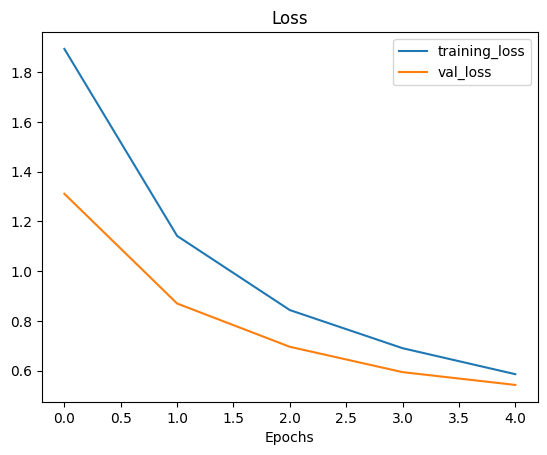

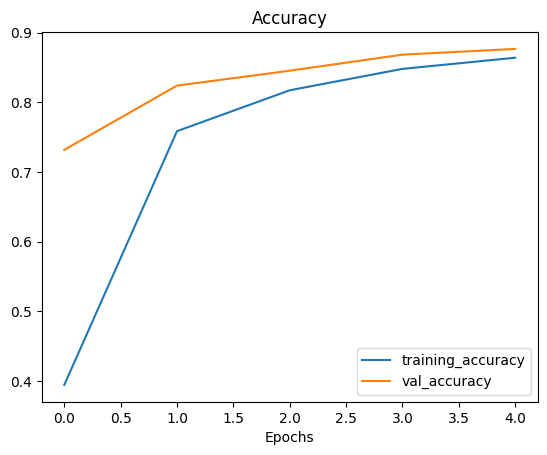

In [16]:
# Check out our model's training curves
plot_loss_curves(model_0_his)

## 4. Getting feature vector from a trained model

Let's demonstrate the Global Avergae Pooling 2D layer

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tesnor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [17]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random tensor: {input_tensor}")

# Pass the random tensor through GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: {global_average_pooled_tensor}")

print(f"Shape of input tensor: {input_tensor.shape}\nShape of global avera tensor: {global_average_pooled_tensor.shape}")

Random tensor: [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
2D global average pooled random tensor: [[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of input tensor: (1, 4, 4, 3)
Shape of global avera tensor: (1, 3)


In [18]:
# Let's replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## 5. Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation.

> **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### 5.1 Setup data

In [19]:
# Download and unzip data
!rm -rf 10_food_classes_1_percent*
!rm -rf 10_food_classes_10_percent*
!rm -rf 10_food_classes_all_data*

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_1_percent.zip")
unzip_data("10_food_classes_10_percent.zip")
unzip_data("10_food_classes_all_data.zip")

!rm -rf 10_food_classes_1_percent.zip
!rm -rf 10_food_classes_10_percent.zip
!rm -rf 10_food_classes_all_data.zip
!rm -rf __MACOSX*

--2024-10-27 09:43:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.209.219, 216.58.211.251, 216.58.209.187, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.209.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  22.0MB/s    in 6.8s    

2024-10-27 09:43:56 (18.6 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]

--2024-10-27 09:43:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.209.219, 216.58.211.251, 216.58.209.187, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.209.219|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [20]:
train_dir_1_percent = "10_food_classes_1_percent/train"
train_dir_10_percent = "10_food_classes_10_percent/train"
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [21]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)


train_data_all = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_all_data,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

Found 70 files belonging to 10 classes.
Found 750 files belonging to 10 classes.
Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### 5.2 Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layerrs inside

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top  out heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on GPU (much faster)
* Image data augmentation only happens during trainng, so we can still export our whole model and use it elsewhere.

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

(-0.5, 609.5, 608.5, -0.5)

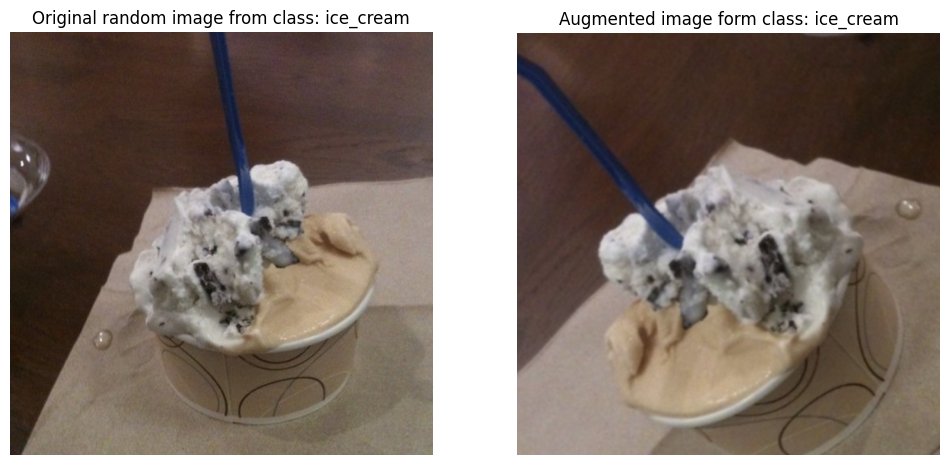

In [23]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read random image
img = mpimg.imread(random_image_path)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(img, training=True)
plt.subplot(1,2,2)
plt.imshow(augmented_img/255)
plt.title(f"Augmented image form class: {target_class}")
plt.axis(False)

### Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [24]:
# Set input shape and base model, freezing the bas model layers
input_shape = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fit the model
model_1_his = model_1.fit(
    train_data_1_percent,
    epochs=5,
    steps_per_epoch=len(train_data_1_percent),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data))
)
        

Epoch 1/5
3/3 [==============================] - 7s 931ms/step - loss: 2.2352 - accuracy: 0.0857 - val_loss: 2.1134 - val_accuracy: 0.2451
Epoch 2/5
3/3 [==============================] - 1s 470ms/step - loss: 1.9794 - accuracy: 0.3429 - val_loss: 1.9910 - val_accuracy: 0.3734
Epoch 3/5
3/3 [==============================] - 1s 455ms/step - loss: 1.8484 - accuracy: 0.5000 - val_loss: 1.8863 - val_accuracy: 0.4375
Epoch 4/5
3/3 [==============================] - 1s 450ms/step - loss: 1.6140 - accuracy: 0.6429 - val_loss: 1.7822 - val_accuracy: 0.4786
Epoch 5/5
3/3 [==============================] - 1s 454ms/step - loss: 1.4969 - accuracy: 0.7143 - val_loss: 1.6947 - val_accuracy: 0.5280


In [25]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, 3)           0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [26]:
# Evaluate on full test dataset
model_1_results = model_1.evaluate(test_data)
model_1_results

79/79 [==============================] - 3s 39ms/step - loss: 1.6991 - accuracy: 0.5336


[1.699080467224121, 0.5335999727249146]

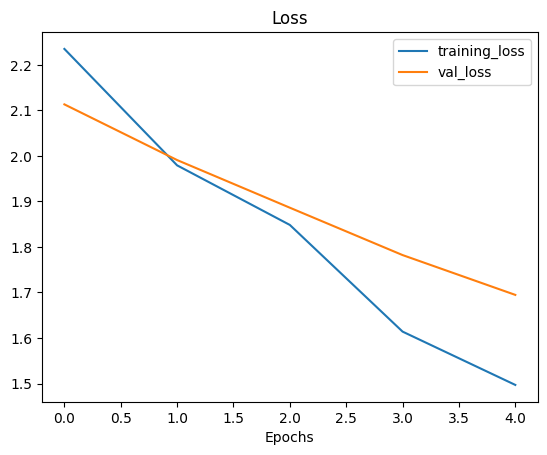

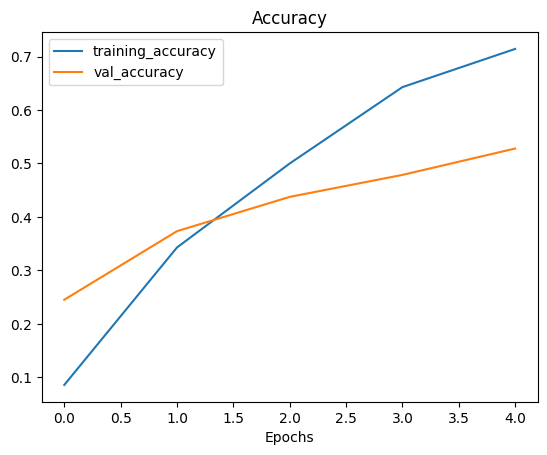

In [27]:
# Plot loss curves
plot_loss_curves(model_1_his)

### Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [28]:
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name="data_augmentation")

# Set up input shape
input_shape = IMAGE_SIZE + (3,)

# Create a frozen base model (alse called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including layers in between
inputs = layers.Input(input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create model 2
model_2 = tf.keras.models.Model(inputs, outputs)

# Compile model 2
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_2.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

### Creating a modelCheckpoint callback

The modelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is usefule so we can come and start where we left off.

In [29]:
# Set checkpoint path
checkpoint_dir = "10_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a modelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_dir,
    save_weights_only=True,
    save_best_only=False,
    save_freq="epoch",
    verbose=1
)

In [30]:
# Fit model 2
model_2_his = model_2.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback]
)

Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9794 - accuracy: 0.3493
Epoch 1: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 269ms/step - loss: 1.9794 - accuracy: 0.3493 - val_loss: 1.4456 - val_accuracy: 0.6680
Epoch 2/5
23/24 [===========================>..] - ETA: 0s - loss: 1.2908 - accuracy: 0.6916
Epoch 2: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 6s 235ms/step - loss: 1.2938 - accuracy: 0.6880 - val_loss: 0.9910 - val_accuracy: 0.7932
Epoch 3/5
23/24 [===========================>..] - ETA: 0s - loss: 0.9766 - accuracy: 0.7758
Epoch 3: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 5s 226ms/step - loss: 0.9866 - accuracy: 0.7733 - val_loss: 0.8000 - val_accuracy: 0.8128
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8243 - accuracy: 0.8027


In [31]:
model_0.evaluate(test_data)

79/79 [==============================] - 2s 24ms/step - loss: 0.5714 - accuracy: 0.8624


[0.5714280605316162, 0.8623999953269958]

In [32]:
model_2_results = model_2.evaluate(test_data)
model_2_results

79/79 [==============================] - 3s 43ms/step - loss: 0.6361 - accuracy: 0.8376


[0.6361286640167236, 0.8375999927520752]

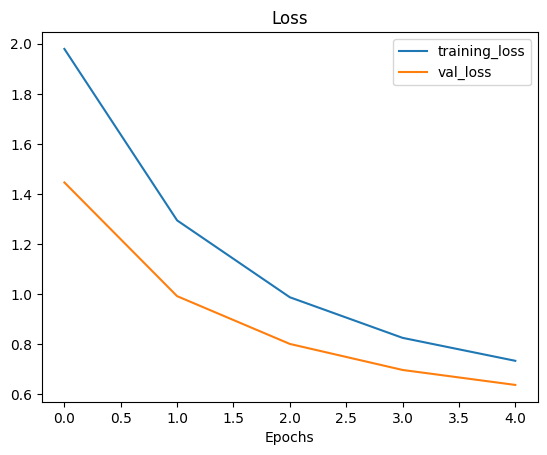

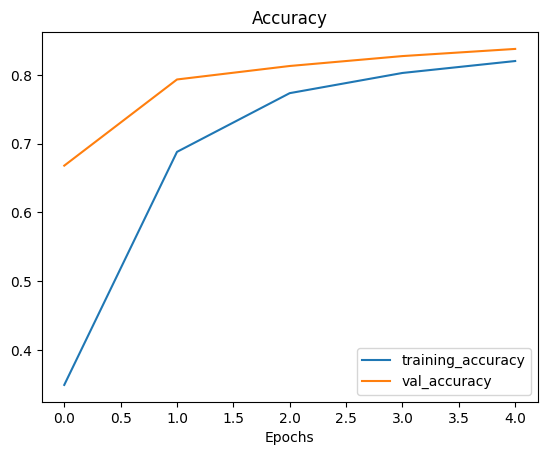

In [33]:
# Plot model loss curves
plot_loss_curves(model_2_his)

### Loading in checkpointed weights

loading in checkpoitned weights returns a model to a specific checkpoint.

In [34]:
model_2.load_weights(checkpoint_dir)
model_2_copy = tf.keras.models.clone_model(model_2)

In [35]:
# Evaluate model 2 with loaded weights
model_2_results_loaded = model_2.evaluate(test_data)

79/79 [==============================] - 3s 39ms/step - loss: 0.6361 - accuracy: 0.8376


In [36]:
model_2_results == model_2_results_loaded

False

In [37]:
# Check to see if loaded results are very close to our non-loaded models
import numpy as np
np.isclose(np.array(model_2_results), np.array(model_2_results_loaded))

array([ True,  True])

In [38]:
# CHeck the difference between the two results
print(np.array(model_2_results) - np.array(model_2_results_loaded))

[-3.57627869e-07  0.00000000e+00]


### Model 3: Fine-tuning an existing model with 10% data

> **NOTE:** Fine-tuning usually works best *after* trainning a feature extraction model for a few epochs with large amounts of custom data.

In [39]:
#  Layers in loaded model
model_2.layers

In [40]:
# Are these layers trainable=
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x74697c46a140> True
<keras.src.engine.sequential.Sequential object at 0x74697c469ff0> True
<keras.src.engine.functional.Functional object at 0x74697c04a1a0> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x74697bf773d0> True
<keras.src.layers.core.dense.Dense object at 0x74697c0ad0f0> True


In [41]:
# What layers are in our base_model
for i, layer in enumerate(model_2.layers[2].layers):
    print(f"{i} \t{layer.name} \t{layer.trainable}")

0 	input_3 	False
1 	rescaling_3 	False
2 	normalization_2 	False
3 	rescaling_4 	False
4 	stem_conv_pad 	False
5 	stem_conv 	False
6 	stem_bn 	False
7 	stem_activation 	False
8 	block1a_dwconv 	False
9 	block1a_bn 	False
10 	block1a_activation 	False
11 	block1a_se_squeeze 	False
12 	block1a_se_reshape 	False
13 	block1a_se_reduce 	False
14 	block1a_se_expand 	False
15 	block1a_se_excite 	False
16 	block1a_project_conv 	False
17 	block1a_project_bn 	False
18 	block2a_expand_conv 	False
19 	block2a_expand_bn 	False
20 	block2a_expand_activation 	False
21 	block2a_dwconv_pad 	False
22 	block2a_dwconv 	False
23 	block2a_bn 	False
24 	block2a_activation 	False
25 	block2a_se_squeeze 	False
26 	block2a_se_reshape 	False
27 	block2a_se_reduce 	False
28 	block2a_se_expand 	False
29 	block2a_se_excite 	False
30 	block2a_project_conv 	False
31 	block2a_project_bn 	False
32 	block2b_expand_conv 	False
33 	block2b_expand_bn 	False
34 	block2b_expand_activation 	False
35 	block2b_dwconv 	False
36

In [42]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [54]:
# To begin fine-tuning, letäs start by setting the last 10 layers of our base model trainable
base_model.trainable = True

# Freeze all layers expect for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower lr
    metrics=["accuracy"]
)

model_4 = tf.keras.models.clone_model(model_2)

> **NOTE:** When using fine-tuning it's best practise to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. Bu a good rule of thumb is at least 10x (tohugh different sources will claim other values). A good resource for informing on this is the ULMFiT-paper: https://arxiv.org/abs/1801.06146

In [44]:
for i, l in enumerate(model_2.layers[2].layers):
    print(f"{i} \t{l.name} \t {l.trainable}")

0 	input_3 	 False
1 	rescaling_3 	 False
2 	normalization_2 	 False
3 	rescaling_4 	 False
4 	stem_conv_pad 	 False
5 	stem_conv 	 False
6 	stem_bn 	 False
7 	stem_activation 	 False
8 	block1a_dwconv 	 False
9 	block1a_bn 	 False
10 	block1a_activation 	 False
11 	block1a_se_squeeze 	 False
12 	block1a_se_reshape 	 False
13 	block1a_se_reduce 	 False
14 	block1a_se_expand 	 False
15 	block1a_se_excite 	 False
16 	block1a_project_conv 	 False
17 	block1a_project_bn 	 False
18 	block2a_expand_conv 	 False
19 	block2a_expand_bn 	 False
20 	block2a_expand_activation 	 False
21 	block2a_dwconv_pad 	 False
22 	block2a_dwconv 	 False
23 	block2a_bn 	 False
24 	block2a_activation 	 False
25 	block2a_se_squeeze 	 False
26 	block2a_se_reshape 	 False
27 	block2a_se_reduce 	 False
28 	block2a_se_expand 	 False
29 	block2a_se_excite 	 False
30 	block2a_project_conv 	 False
31 	block2a_project_bn 	 False
32 	block2b_expand_conv 	 False
33 	block2b_expand_bn 	 False
34 	block2b_expand_activation 	

In [45]:
print(len(model_2.trainable_variables))

12


In [46]:
# Fine tune for another 5 epochs
model_2_his_finetune = model_2.fit(
    train_data_10_percent,
    epochs=10,
    initial_epoch=model_2_his.epoch[-1],
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data))
)

Epoch 5/10
24/24 [==============================] - 21s 632ms/step - loss: 0.7682 - accuracy: 0.7493 - val_loss: 0.6418 - val_accuracy: 0.7845
Epoch 6/10
24/24 [==============================] - 12s 514ms/step - loss: 0.3628 - accuracy: 0.8707 - val_loss: 0.4519 - val_accuracy: 0.8536
Epoch 7/10
24/24 [==============================] - 11s 453ms/step - loss: 0.1628 - accuracy: 0.9493 - val_loss: 0.5309 - val_accuracy: 0.8536
Epoch 8/10
24/24 [==============================] - 10s 417ms/step - loss: 0.1300 - accuracy: 0.9600 - val_loss: 0.5857 - val_accuracy: 0.8651
Epoch 9/10
24/24 [==============================] - 9s 374ms/step - loss: 0.0905 - accuracy: 0.9640 - val_loss: 0.6149 - val_accuracy: 0.8339
Epoch 10/10
24/24 [==============================] - 8s 350ms/step - loss: 0.0636 - accuracy: 0.9827 - val_loss: 0.5998 - val_accuracy: 0.8569


In [47]:
# Evaluate the fin-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
model_2_results_finetuned = model_2.evaluate(test_data)
model_2_results_finetuned

79/79 [==============================] - 3s 39ms/step - loss: 0.5385 - accuracy: 0.8624


[0.5385162830352783, 0.8623999953269958]

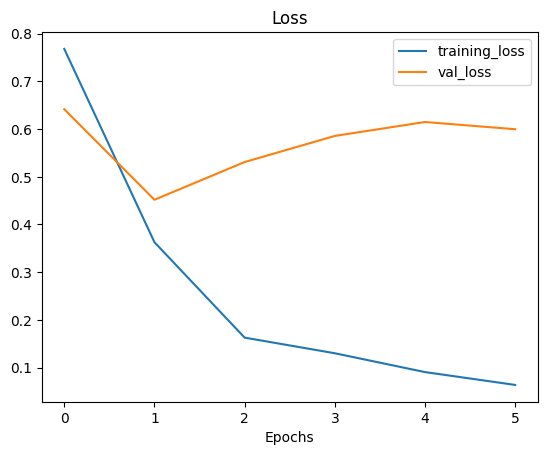

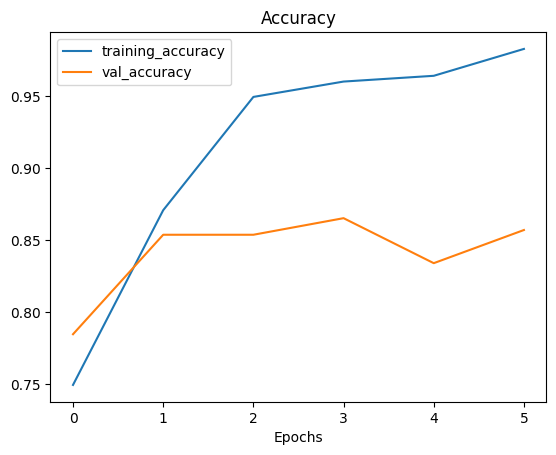

In [48]:
plot_loss_curves(model_2_his_finetune)

In [49]:
# Let's create a function to compare training histories
def compare_history(oghis, newhis, initial_epochs=5):
    acc = oghis.history["accuracy"]
    loss = oghis.history["loss"]
    val_acc = oghis.history["val_accuracy"]
    val_loss = oghis.history["val_loss"]
    total_acc = acc + newhis.history["accuracy"]
    total_loss = loss + newhis.history["loss"]
    total_val_acc = val_acc + newhis.history["val_accuracy"]
    total_val_loss = val_loss + newhis.history["val_loss"]
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label="Training accuracy")
    plt.plot(total_val_acc, label="Val accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")
    plt.subplot(2,1,2)
    plt.plot(total_loss, label="Training loss")
    plt.plot(total_val_loss, label="Val loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Loss")

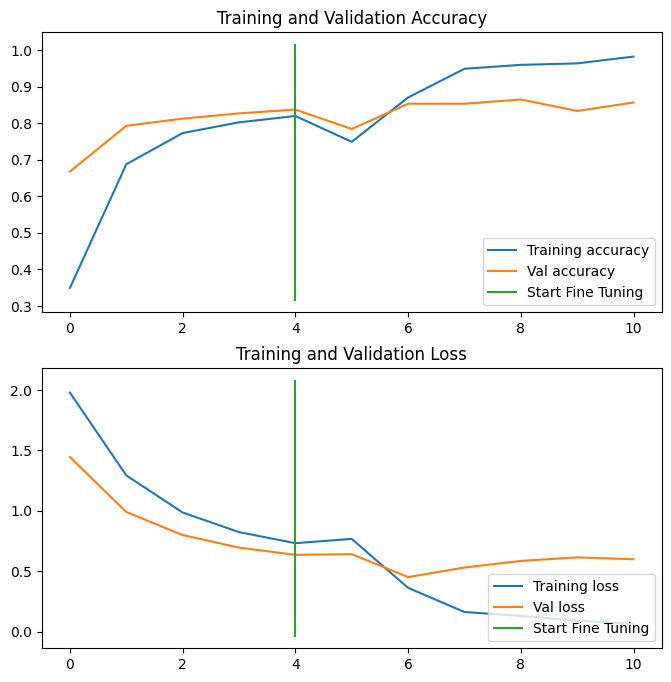

In [50]:
compare_history(model_2_his, model_2_his_finetune)

### Model 4: Fine-tuning and existing model on all data

In [62]:
# Load model from checkpoint, that way we can fine-tune from
# same stage as last time
model_4.load_weights(checkpoint_dir)

# Compile model 4
model_4.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=10**-4),
    metrics=["accuracy"]
)

In [63]:
# Let's evaluate model 4 
model_4.evaluate(test_data)

79/79 [==============================] - 5s 39ms/step - loss: 0.7085 - accuracy: 0.8040


[0.7084881067276001, 0.8040000200271606]

In [64]:
model_2.evaluate(test_data)

79/79 [==============================] - 5s 39ms/step - loss: 0.6361 - accuracy: 0.8376


[0.6361286640167236, 0.8375999927520752]

Alright, the previous steps might seem quite confusing but aall we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 105% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4).

In [65]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_4.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling True
4 output_layer True


In [67]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_4.layers[2].layers):
    print(f"{layer_number} \t{layer.name} \t{layer.trainable}")


0 	input_3 	True
1 	rescaling_3 	False
2 	normalization_2 	False
3 	rescaling_4 	False
4 	stem_conv_pad 	False
5 	stem_conv 	False
6 	stem_bn 	False
7 	stem_activation 	False
8 	block1a_dwconv 	False
9 	block1a_bn 	False
10 	block1a_activation 	False
11 	block1a_se_squeeze 	False
12 	block1a_se_reshape 	False
13 	block1a_se_reduce 	False
14 	block1a_se_expand 	False
15 	block1a_se_excite 	False
16 	block1a_project_conv 	False
17 	block1a_project_bn 	False
18 	block2a_expand_conv 	False
19 	block2a_expand_bn 	False
20 	block2a_expand_activation 	False
21 	block2a_dwconv_pad 	False
22 	block2a_dwconv 	False
23 	block2a_bn 	False
24 	block2a_activation 	False
25 	block2a_se_squeeze 	False
26 	block2a_se_reshape 	False
27 	block2a_se_reduce 	False
28 	block2a_se_expand 	False
29 	block2a_se_excite 	False
30 	block2a_project_conv 	False
31 	block2a_project_bn 	False
32 	block2b_expand_conv 	False
33 	block2b_expand_bn 	False
34 	block2b_expand_activation 	False
35 	block2b_dwconv 	False
36 

In [68]:
# Fit the model
model_4_his = model_4.fit(
    train_data_all,
    epochs=10,
    initial_epoch=model_2_his.epoch[-1],
    steps_per_epoch=len(train_data_all),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data))
)

Epoch 5/10
235/235 [==============================] - 69s 270ms/step - loss: 0.7770 - accuracy: 0.7483 - val_loss: 0.4942 - val_accuracy: 0.8421
Epoch 6/10
235/235 [==============================] - 55s 232ms/step - loss: 0.6260 - accuracy: 0.7977 - val_loss: 0.3765 - val_accuracy: 0.8816
Epoch 7/10
235/235 [==============================] - 44s 189ms/step - loss: 0.5505 - accuracy: 0.8196 - val_loss: 0.3553 - val_accuracy: 0.8783
Epoch 8/10
235/235 [==============================] - 43s 182ms/step - loss: 0.5135 - accuracy: 0.8352 - val_loss: 0.3723 - val_accuracy: 0.8832
Epoch 9/10
235/235 [==============================] - 38s 164ms/step - loss: 0.4722 - accuracy: 0.8519 - val_loss: 0.3673 - val_accuracy: 0.8882
Epoch 10/10
235/235 [==============================] - 33s 142ms/step - loss: 0.4455 - accuracy: 0.8561 - val_loss: 0.3257 - val_accuracy: 0.8964


In [74]:
# Let's evaluate all test data
model_4_results = model_4.evaluate(test_data)
model_4_results

79/79 [==============================] - 3s 39ms/step - loss: 0.3465 - accuracy: 0.8920


[0.3465278148651123, 0.8920000195503235]

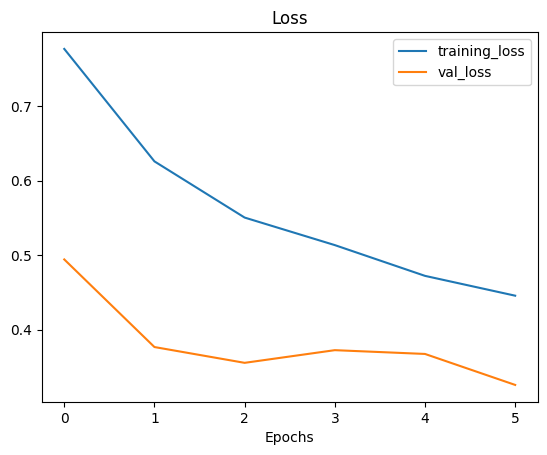

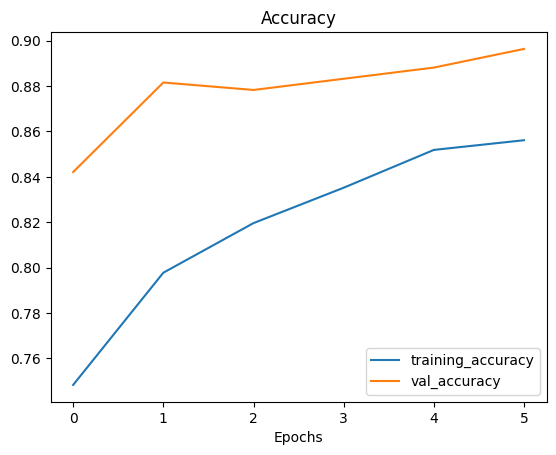

In [75]:
plot_loss_curves(model_4_his)

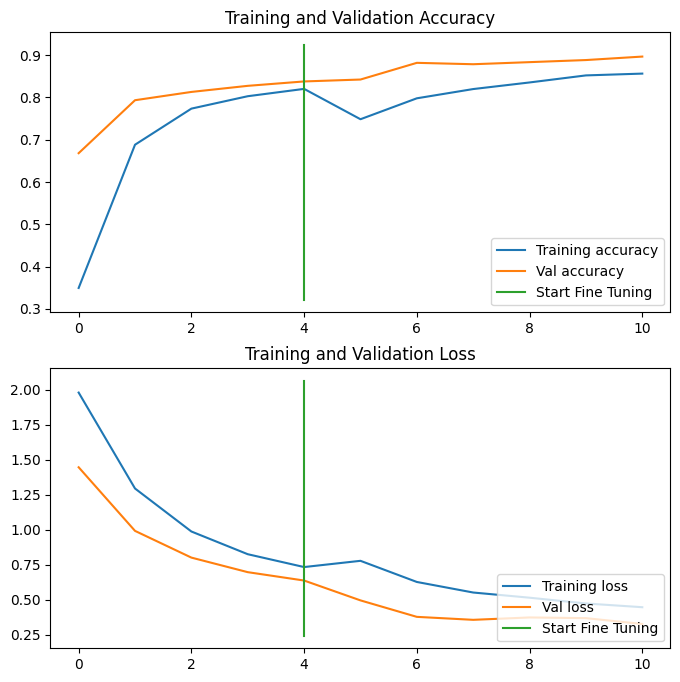

In [76]:
compare_history(model_2_his, model_4_his)

In [ ]:
!rm -rf 10_food_classes_1_percent/
!rm -rf 10_food_classes_10_percent/
!rm -rf 10_food_classes_all_data/
!rm -rf 10_percent_model_checkpoints_weights/
!rm -rf transfer_learning/
!rm -rf helper_functions.py